## Which are top key indicators on prices of listings?

From the listings dataset, we want to make a prediction on listings prices and understand which are the top key indicators on prices of listings

### Gather Data

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline


calendar=pd.read_csv("calendar.csv")
listings=pd.read_csv("listings.csv")
reviews=pd.read_csv("reviews.csv")


We convert price column, as target variable, to float instead of string. Also other 'prices' columns.

In [23]:
listings[['price','monthly_price','weekly_price']]=listings[['price','monthly_price','weekly_price']].replace({'\$': '', ',': ''}, regex=True).astype(float)

We check the percentage of null values in price column.

In [24]:
listings['price'].isnull().sum()/listings.shape[0]

0.0

Getting a full description for all numerical columns in our dataframe.

In [25]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


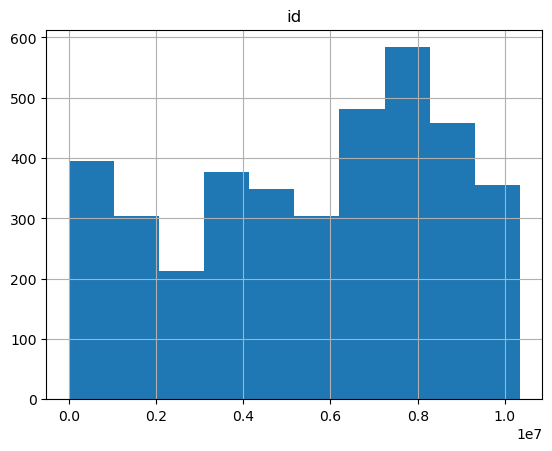

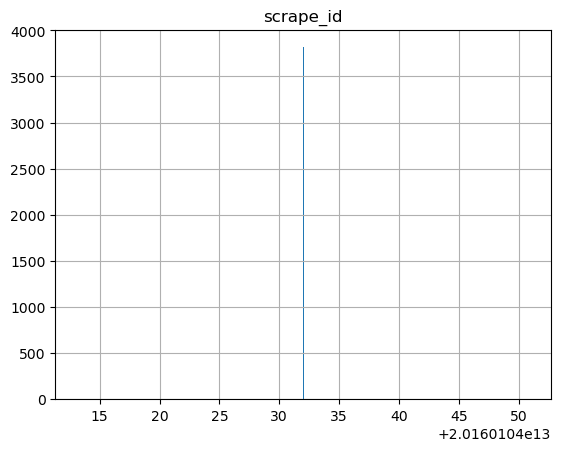

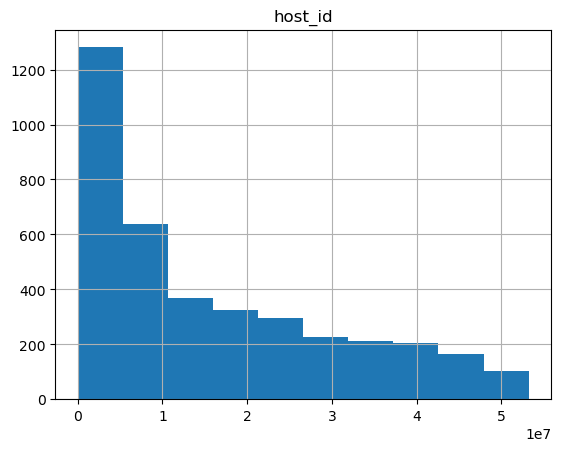

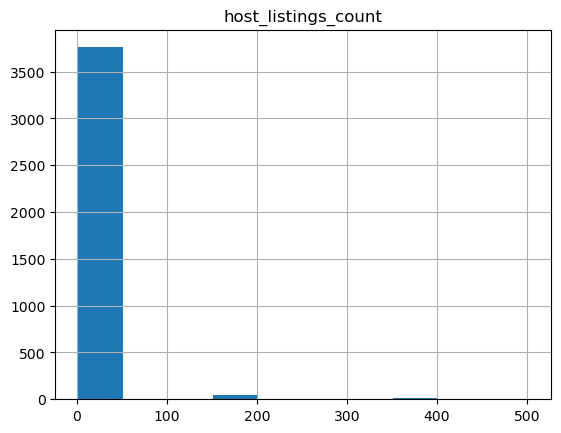

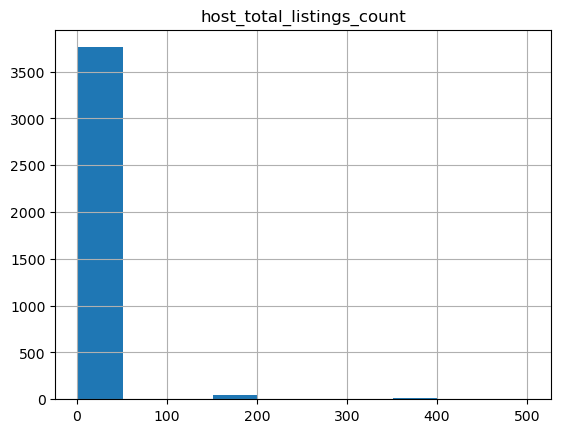

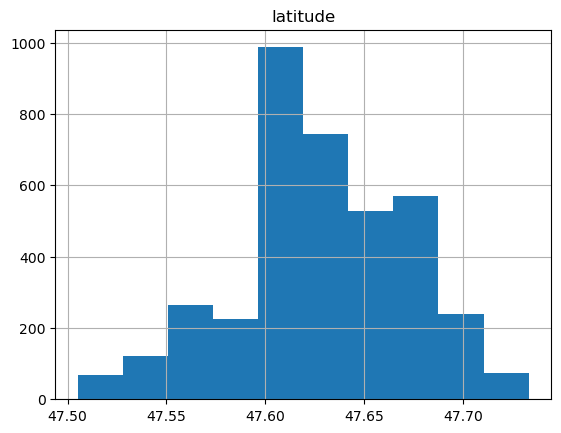

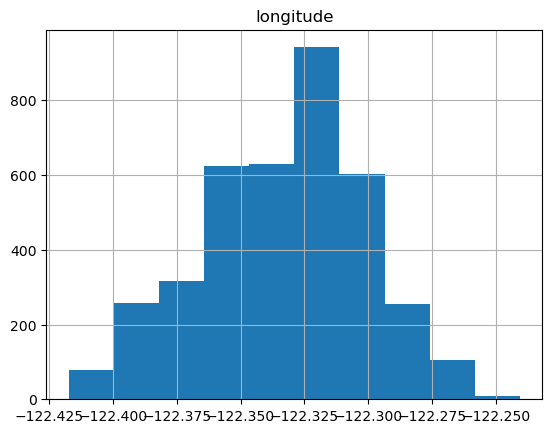

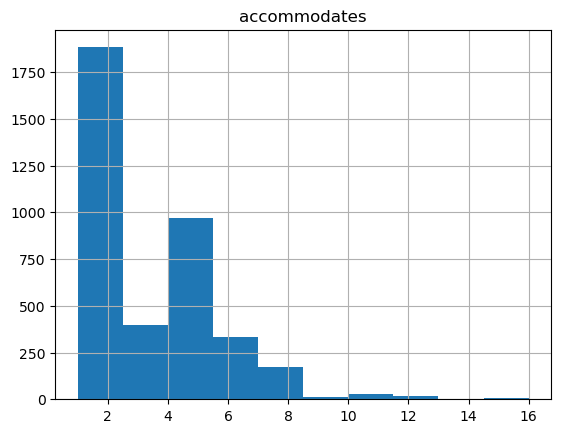

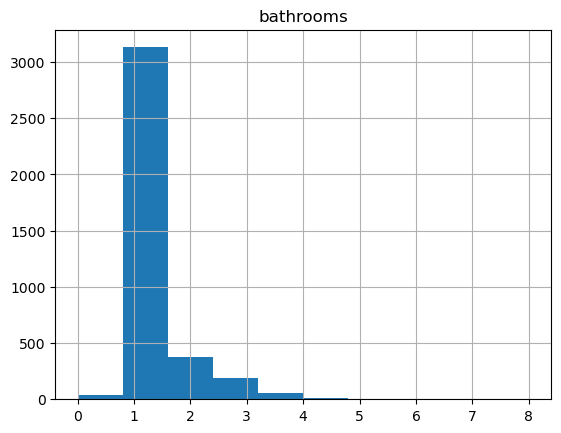

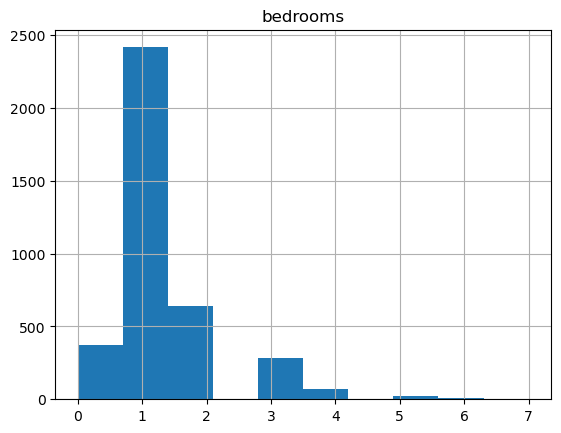

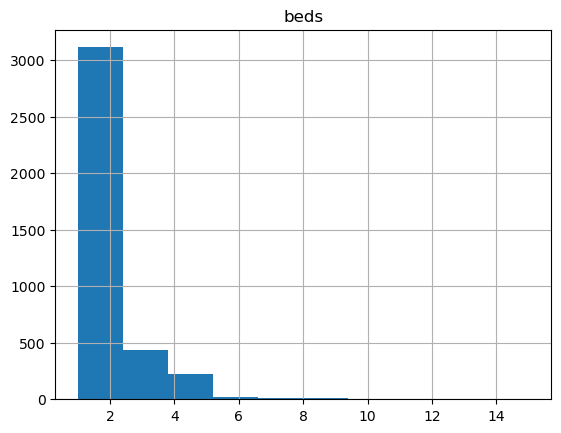

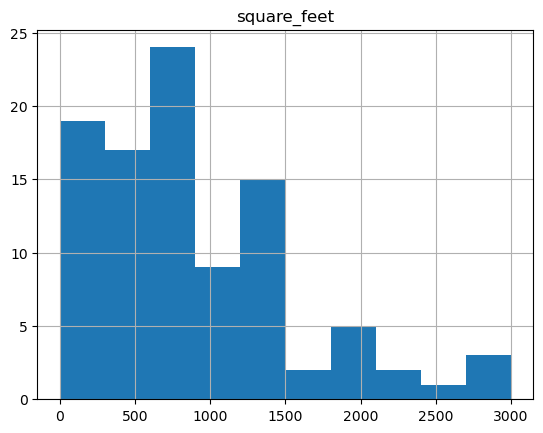

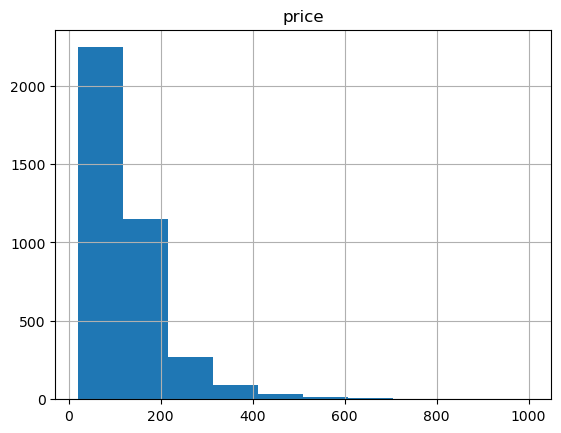

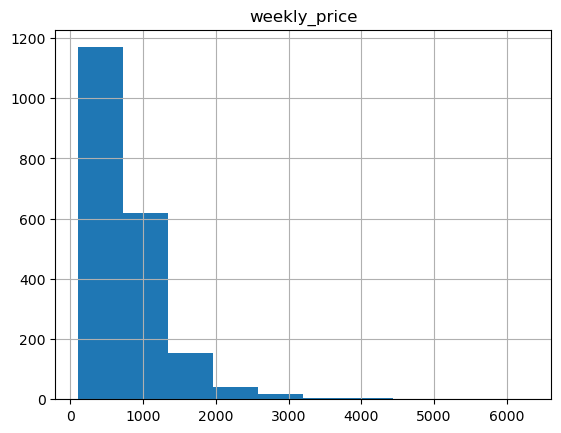

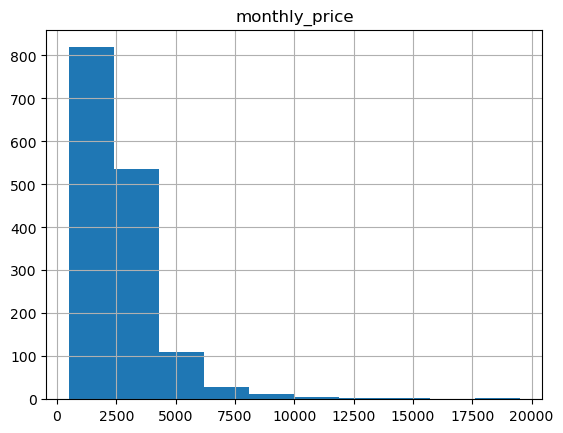

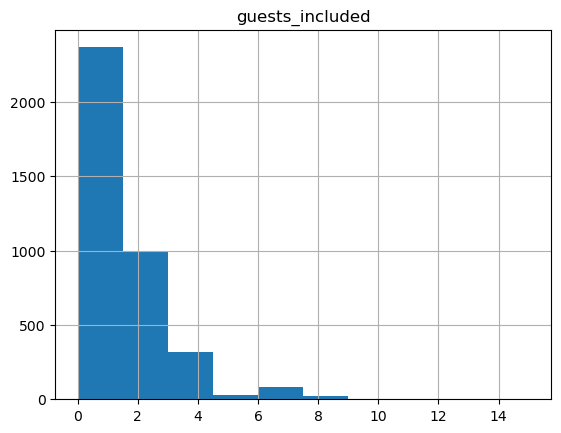

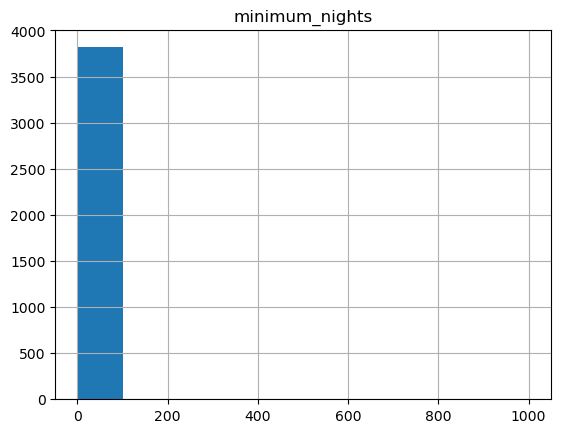

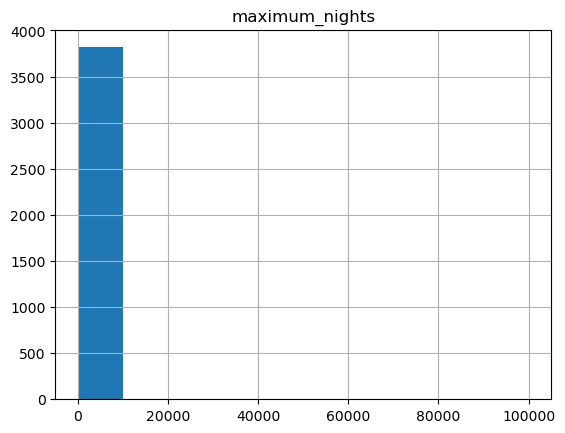

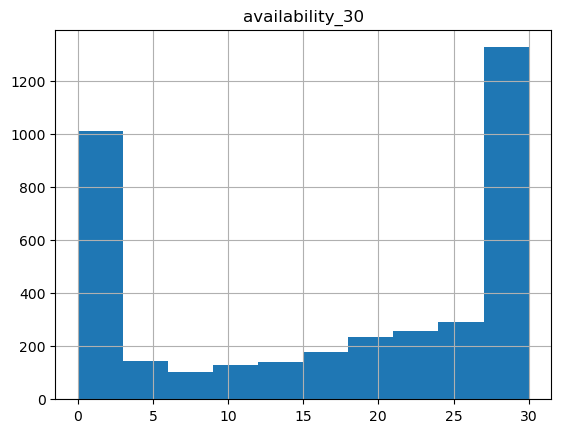

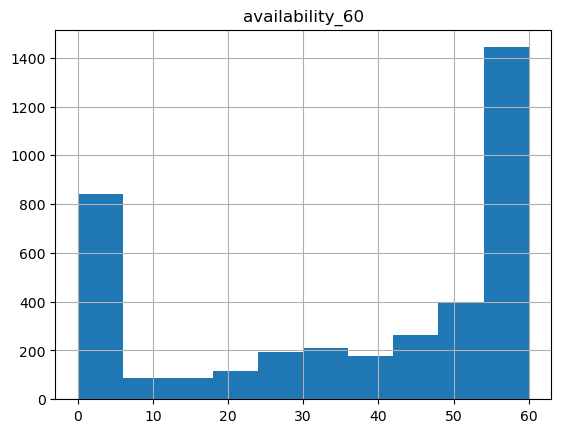

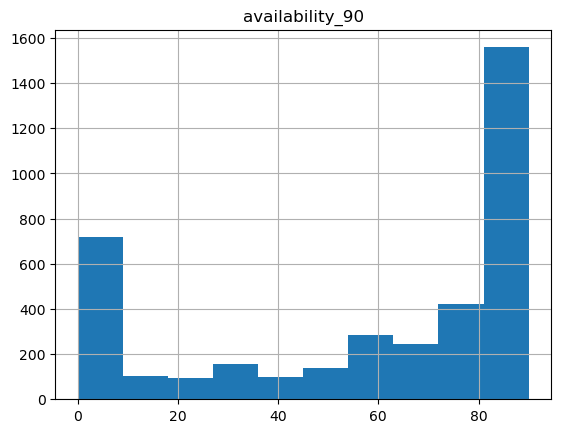

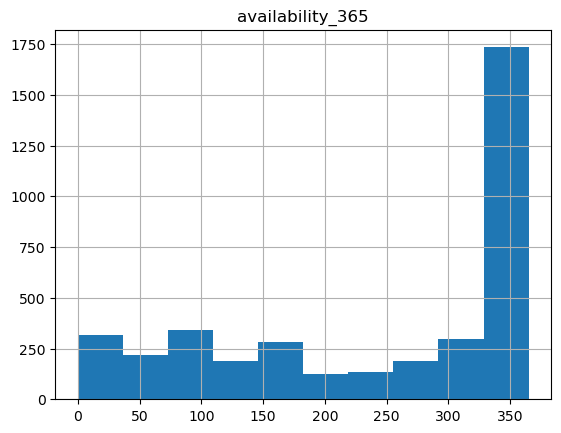

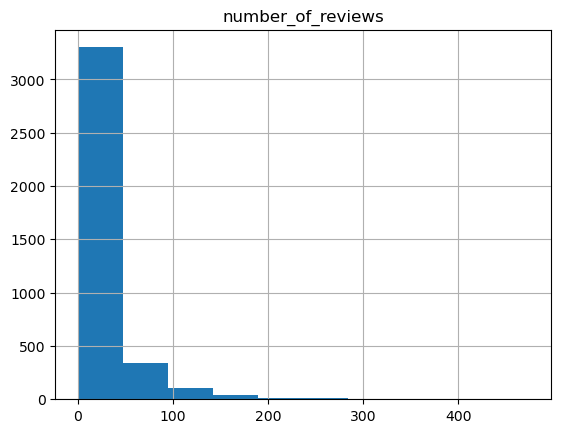

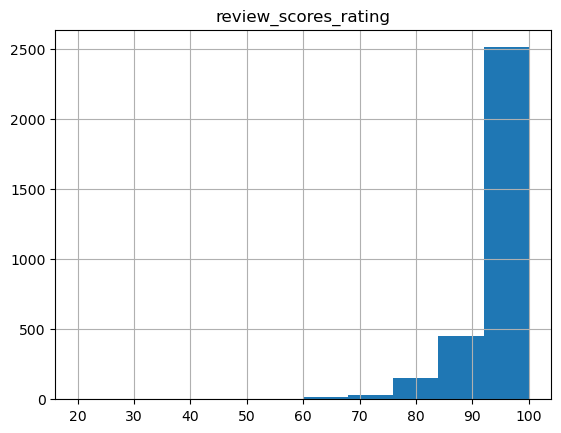

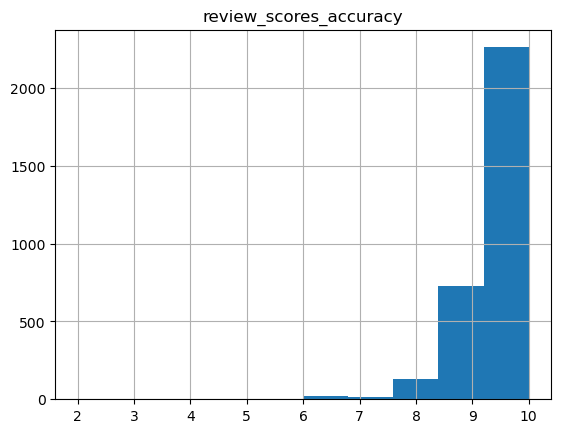

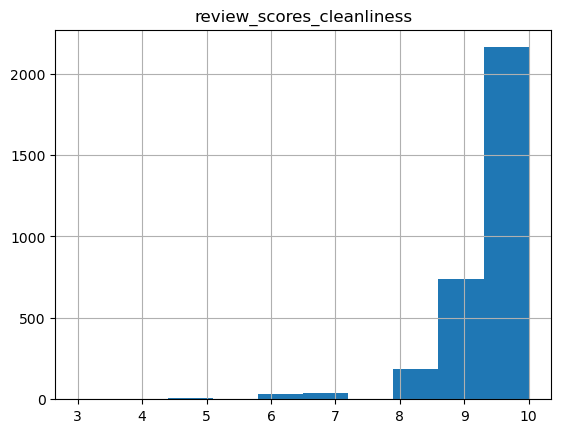

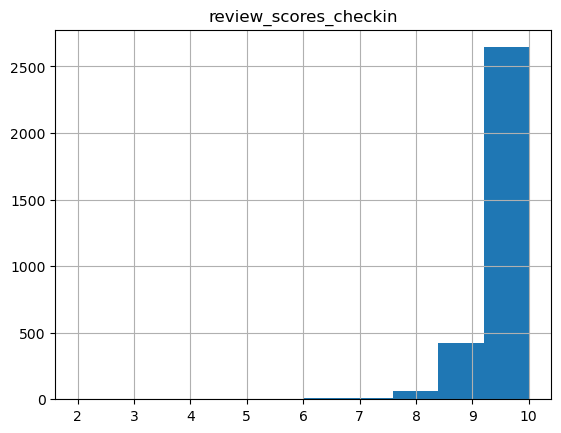

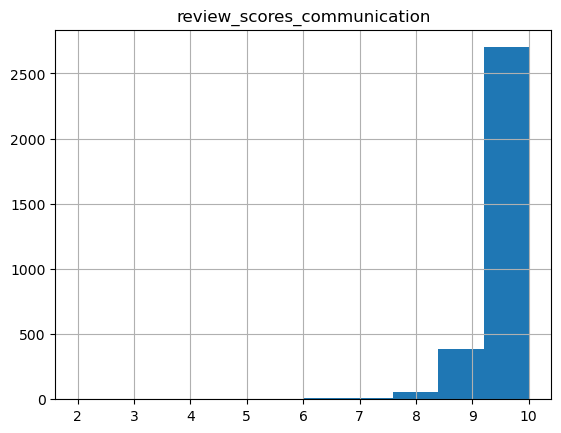

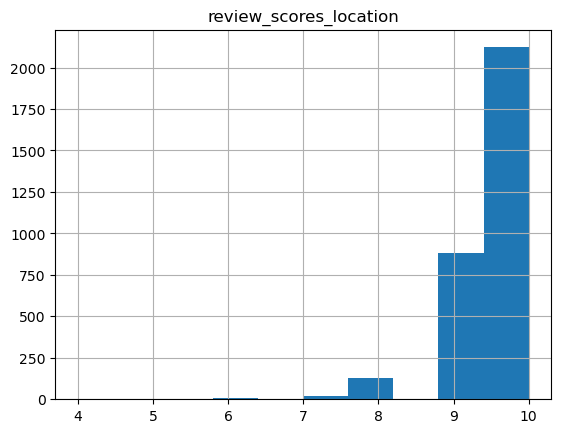

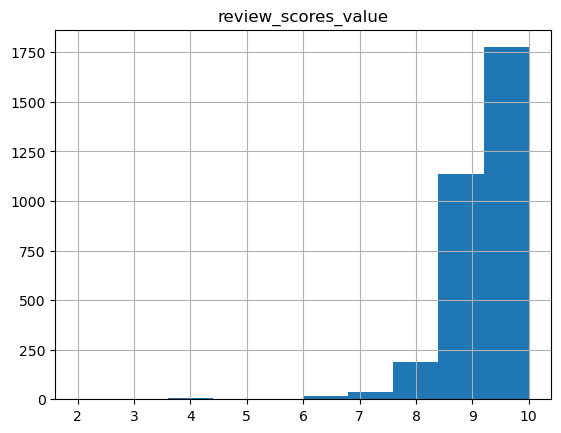

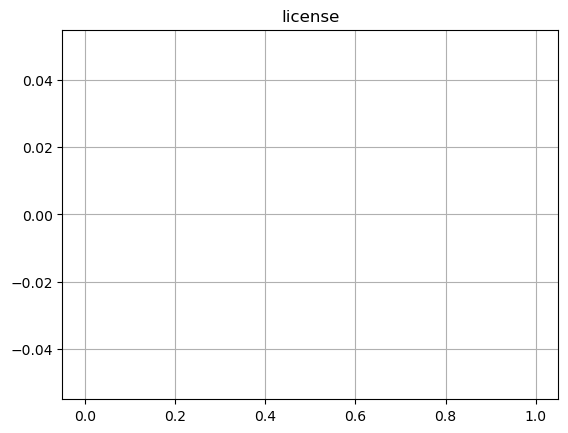

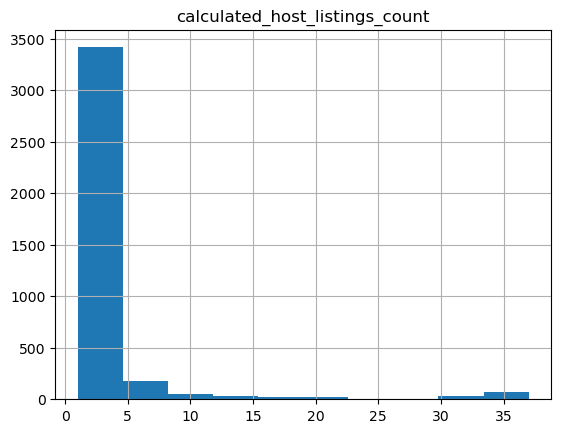

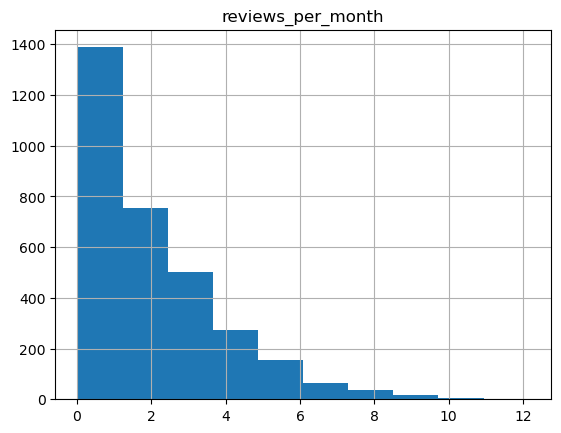

In [26]:
for columns in listings_num.columns:
    listings_num[columns].hist()
    plt.title(columns)
    plt.show()

We draw a correlation matrix to understand which variables or features are most correlated with each other.

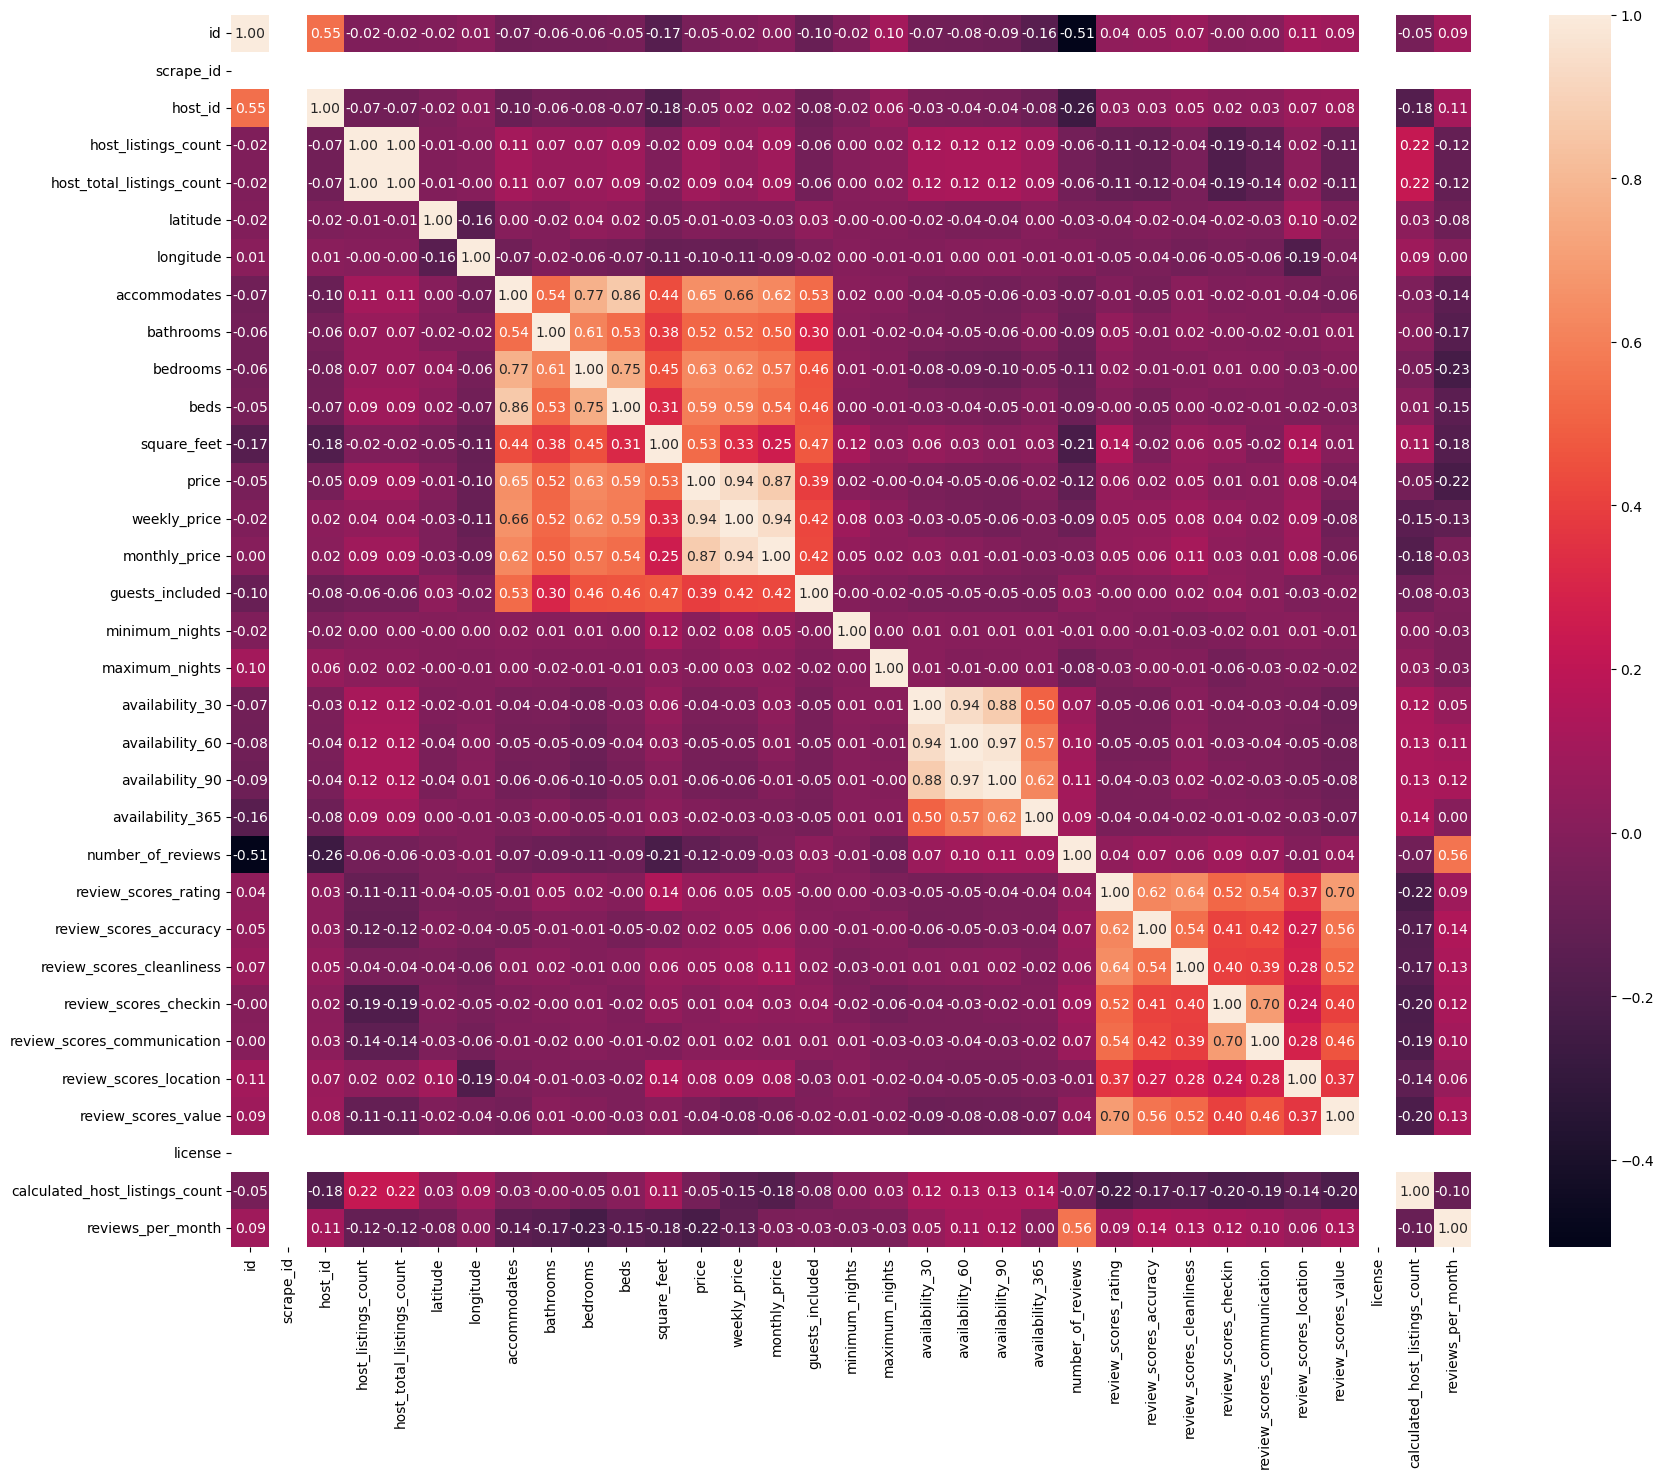

In [27]:
plt.figure(figsize=(20,16))

sns.heatmap(listings.select_dtypes(exclude='object').corr(),annot=True,fmt='.2f')

plt.show()

### Clean Data

Dropping all null rows in price column as we are not predicting for null values.
Dropping all null columns because all null columns are irrelevant for predictions.
Dropping not important features by using Random Forest Regressor. From this model we get feature importances as coefficients and sort them ascending to get the lowest coefficients and remove them from our model to avoid overfitting and get better results on our prediction and R2.





In [28]:
listings=listings.dropna(subset=['price'],axis=0)
null_columns = listings.columns[listings.isnull().all()]
listings.drop(null_columns, axis=1, inplace=True)
y=listings['price']
listings=listings.drop(['scrape_id','price','thumbnail_url',
                        'medium_url','picture_url','xl_picture_url','host_url',
                        'host_thumbnail_url', 'host_picture_url','listing_url','neighborhood_overview','street','host_about'
                        ,'description','notes','transit','space','host_name','summary','host_since','calendar_updated','last_review'
                        ,'amenities','name','host_verifications','first_review','host_location'
                       ],axis=1)




### Data Preparation

From the X df we identify numerical columns to fill null values in these columns with mean value of the column. Also for categorical values we create dumy values.

In [29]:
num_vars=listings.select_dtypes(exclude='object').columns
for col in num_vars:
    listings[col].fillna((listings[col].mean()),inplace=True)

obj_vars=listings.select_dtypes(include='object').columns
for obj in obj_vars:
    listings=pd.concat([listings.drop(obj, axis=1), pd.get_dummies(listings[obj], prefix=obj, prefix_sep='_', drop_first=True)], axis=1)
X=listings

Using RandomForestRegressor to find most important and non important features of dataset in order to avoid overfitting in our prediction model. We get the lowest coefficients of our dataset and remove those columns from dataset.


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .40, random_state=42) 
model = RandomForestRegressor()

model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

In [32]:
#Check the number of columns now for X matrix
X_train.shape[1]

637

In [33]:
indices = np.argsort(importances)[::]
k = 40
selected_feature_indices = indices[:k]
selected_feature_indices
X_train= X_train.iloc[:,selected_feature_indices]
X_train

,cleaning_fee_$179.00,security_deposit_$140.00,security_deposit_$149.00,cleaning_fee_$178.00,security_deposit_$180.00,host_neighbourhood_Long Beach,city_West Seattle,security_deposit_$195.00,security_deposit_$134.00,security_deposit_$220.00,...,"smart_location_西雅图, WA",cleaning_fee_$27.00,property_type_Chalet,cleaning_fee_$189.00,property_type_Dorm,cleaning_fee_$22.00,"security_deposit_$1,900.00",host_neighbourhood_Baldwin Hills,security_deposit_$499.00,security_deposit_$550.00
660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3091,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Modeling

We split X and Y matrices into test and train datasets with test size =0.4. Then we use Lasso model with regularization in order to avoid overfitting and get desired results. We fit the model and then get predictions for test and train data to compare and see if results are nearly the same

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .40, random_state=42) 

lasso_model=Lasso(alpha=0.1)

lasso_model.fit(X_train,y_train)

y_test_preds=lasso_model.predict(X_test)
y_train_preds=lasso_model.predict(X_train)

test_scores=r2_score(y_test,y_test_preds)
train_scores=r2_score(y_train,y_train_preds)

print("Test Score for our model is :",test_scores,"and Train Score for our model is :",train_scores)

Test Score for our model is : 0.6593779221655145 and Train Score for our model is : 0.6973426249163466


We get the features coefficients and insert them in a dataset ordering descending by their absolut value of coefficient to get the most impactful features on listings price

In [35]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lasso_model.coef_
coefs_df['abs_coefs'] = np.abs(lasso_model.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)


coefs_df1=coefs_df.head(20)
coefs_df1

,est_int,coefs,abs_coefs
539,cleaning_fee_$275.00,165.269403,165.269403
543,cleaning_fee_$300.00,57.664657,57.664657
421,room_type_Shared room,-55.261850,55.261850
324,neighbourhood_cleansed_Ravenna,-45.312076,45.312076
117,host_neighbourhood_Holly,44.434575,44.434575
242,neighbourhood_Ravenna,43.727798,43.727798
326,neighbourhood_cleansed_Roosevelt,41.336071,41.336071
85,host_neighbourhood_Beverly Hills,33.629899,33.629899
500,cleaning_fee_$150.00,31.737536,31.737536
477,cleaning_fee_$109.00,-31.329746,31.329746


### Evaluating Results

Plot these coefficients and feature name to better understand the most impactful features.

In [37]:
def plottingCoef(dtframe,x,y):
    """
    This function is used to plot coefficients of features found from script above.
    
    Input :
    dtframe - dataframe which contains columns we want to plot.
    x- column we wnat to plot in x axis from dataframe specified.
    y- column we want to plot in y axis from dataframe specified.
    
    Output:
    A horizontal bar chart in ascending order from the lowest impactful features to larges for first 20 most impactful
    features in dataframe.
    
    """
    plt.figure(figsize=(10,6))
    plt.barh(coefs_df1[x],coefs_df1[y],color='green')
    plt.xlabel("Coefficient")
    plt.title("Most impactful features in listings prices")

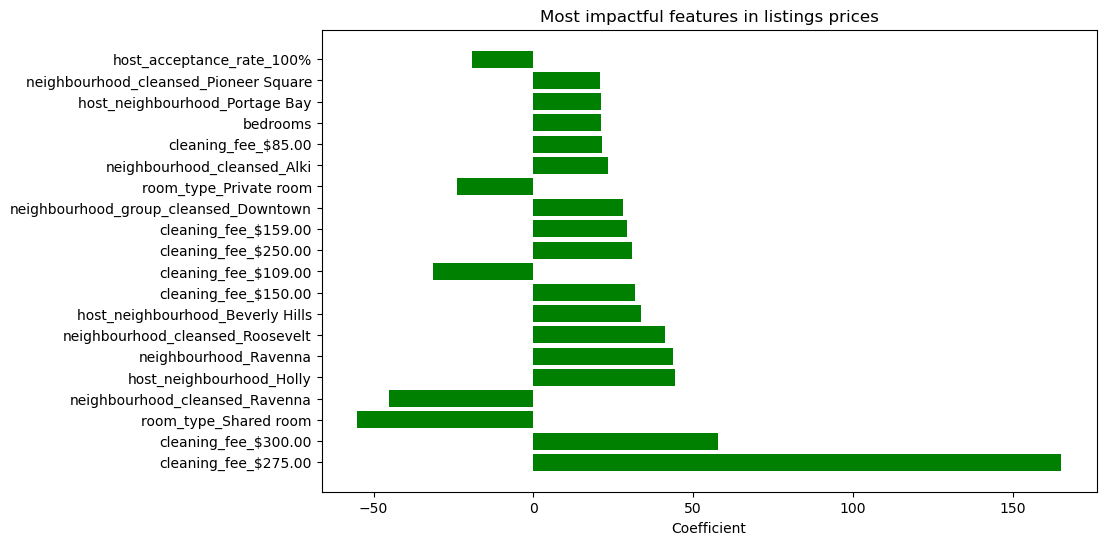

In [38]:
plottingCoef(coefs_df1,'est_int','coefs')

In summary, features such as cleaning fees, host location, and room conditions have a significant impact on listing prices. These features can either positively or negatively affect the price, with larger coefficients indicating a stronger influence. Understanding these factors is valuable for determining the pricing dynamics in the dataset.